In [1]:
import pandas as pd

# Cargar el CSV (asegúrate de subirlo a tu entorno en Colab)
df = pd.read_csv("tarifas_electricas.csv")

# Ver las primeras filas
df.head()

,nombre,proveedor,tipo,precio_punta,precio_valle,permanencia,autoconsumo,condiciones,ideal
0,Tempo Happy 2 horas,Endesa,Discriminación horaria,0.15,0.10,No,Sí,Elige 2 horas con coste 0 €/kWh,Consumo concentrado en franjas cortas
1,Tempo Verde,Endesa,Energía verde,0.17,0.13,No,Sí,100% energía renovable,Usuarios ecológicos
2,One Luz,Endesa,Precio estable,0.14,0.14,Sí,No,Precio fijo 12 meses,Consumo constante
3,Tempo Happy Día,Endesa,Discriminación diaria,0.16,0.11,No,Sí,1 día/semana gratis,Consumo alto un día a la semana
4,Libre 24h,Endesa,Precio libre,0.19,0.19,No,No,Sin permanencia,Usuarios imprevisibles


In [2]:
!pip install -q faiss-cpu sentence-transformers langchain langchain-community

In [3]:
import pandas as pd

df = pd.read_csv("tarifas_electricas.csv")

# Convertimos cada fila a texto plano para embebido
def fila_a_texto(fila):
    return f"""
Nombre de la tarifa: {fila['nombre']}
Proveedor: {fila['proveedor']}
Tipo: {fila['tipo']}
Precio energía punta: {fila['precio_punta']} €/kWh
Precio energía valle: {fila['precio_valle']} €/kWh
Permanencia: {fila['permanencia']}
Compatible con autoconsumo: {fila['autoconsumo']}
Condiciones especiales: {fila['condiciones']}
Ideal para: {fila['ideal']}
""".strip()

documentos = df.apply(fila_a_texto, axis=1).tolist()

In [4]:
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document

# Usamos modelo ligero para embeddings
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Convertimos a lista de Document para LangChain
docs = [Document(page_content=texto) for texto in documentos]

# Creamos el vectorstore
vectorstore = FAISS.from_documents(docs, embedding_model)

/var/folders/zd/htp835012l17qllj6_mzylw80000gn/T/ipykernel_6695/3527413842.py:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


In [5]:
# Perfil de consumo: usuario que consume 80% de energía entre las 00:00 y las 08:00
consulta = "Tarifa ideal para un usuario que consume principalmente por la noche (00:00 a 08:00), 250 kWh al mes"

resultados = vectorstore.similarity_search(consulta, k=3)

for i, r in enumerate(resultados, 1):
    print(f"\n=== Resultado {i} ===\n")
    print(r.page_content)


=== Resultado 1 ===

Nombre de la tarifa: Plan Noche
Proveedor: Iberdrola
Tipo: Discriminación horaria
Precio energía punta: 0.18 €/kWh
Precio energía valle: 0.08 €/kWh
Permanencia: Sí
Compatible con autoconsumo: No
Condiciones especiales: Precio reducido de 00:00 a 08:00
Ideal para: Consumo nocturno

=== Resultado 2 ===

Nombre de la tarifa: Tarifa Vehículo Eléctrico
Proveedor: Repsol
Tipo: Especial
Precio energía punta: 0.22 €/kWh
Precio energía valle: 0.05 €/kWh
Permanencia: Sí
Compatible con autoconsumo: Sí
Condiciones especiales: Pensada para coche eléctrico
Ideal para: Carga nocturna de coche

=== Resultado 3 ===

Nombre de la tarifa: Ahorro Plus
Proveedor: Repsol
Tipo: Estable
Precio energía punta: 0.13 €/kWh
Precio energía valle: 0.13 €/kWh
Permanencia: No
Compatible con autoconsumo: No
Condiciones especiales: Sin permanencia
Ideal para: Consumo sin picos


In [6]:
!pip install openai

from openai import OpenAI
import os

# Inserta tu clave
import os
from getpass import getpass

os.environ["OPENAI_API_KEY"] = getpass("Introduce tu API key de OpenAI: ")

from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA

# Configura el modelo de chat
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.3)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=vectorstore.as_retriever(search_kwargs={"k": 3}),
    return_source_documents=True
)

respuesta = qa_chain(
    {"query": "¿Qué tarifa eléctrica me conviene si consumo casi todo por la noche y tengo coche eléctrico?"}
)

print("Respuesta generada:\n", respuesta["result"])
print("\nDocumentos usados como contexto:\n")
for doc in respuesta["source_documents"]:
    print(doc.page_content)

print(respuesta)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Introduce tu API key de OpenAI:  ········


/var/folders/zd/htp835012l17qllj6_mzylw80000gn/T/ipykernel_6695/3657380052.py:16: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.3)
/var/folders/zd/htp835012l17qllj6_mzylw80000gn/T/ipykernel_6695/3657380052.py:24: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  respuesta = qa_chain(


Respuesta generada:
 La tarifa que te conviene si consumes casi todo por la noche y tienes un coche eléctrico es la "Tarifa Vehículo Eléctrico" de Repsol. Esta tarifa es ideal para la carga nocturna de coche eléctrico, tiene precios especiales tanto en energía punta como en energía valle, y es compatible con el autoconsumo. Además, tiene una permanencia.

Documentos usados como contexto:

Nombre de la tarifa: Tarifa Vehículo Eléctrico
Proveedor: Repsol
Tipo: Especial
Precio energía punta: 0.22 €/kWh
Precio energía valle: 0.05 €/kWh
Permanencia: Sí
Compatible con autoconsumo: Sí
Condiciones especiales: Pensada para coche eléctrico
Ideal para: Carga nocturna de coche
Nombre de la tarifa: Ahorro Plus
Proveedor: Repsol
Tipo: Estable
Precio energía punta: 0.13 €/kWh
Precio energía valle: 0.13 €/kWh
Permanencia: No
Compatible con autoconsumo: No
Condiciones especiales: Sin permanencia
Ideal para: Consumo sin picos
Nombre de la tarifa: Tempo Happy 2 horas
Proveedor: Endesa
Tipo: Discriminació

In [ ]:
import json
from datasets import Dataset

data = []
with open("tarifas_finetune_clean.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line))

dataset = Dataset.from_list(data)

In [13]:
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig
from datasets import load_dataset, Features, Value

# 🟡 Token de Hugging Face
HF_TOKEN = "USE YOUR HF TOKEN"

# Definir el esquema del dataset
features = Features({
    "prompt": Value("string"),
    "completion": Value("string"),
})

# Cargar dataset completo y dividir en train/val
raw_dataset = load_dataset(
    "json",
    data_files="tarifas_finetune_clean.jsonl",
    split="train[:100]",  # Puedes cambiar el tamaño aquí
    features=features
)
dataset = raw_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

# Cargar tokenizer
model_name = "tiiuae/falcon-rw-1b"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=HF_TOKEN)
tokenizer.pad_token = tokenizer.eos_token  # necesario para evitar errores de padding

# Función de tokenización
def tokenize(example):
    full_input = example["prompt"] + "\n" + example["completion"]
    tokenized = tokenizer(full_input, truncation=True, padding="max_length", max_length=512)
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

# Tokenizar datasets
tokenized_train = train_dataset.map(tokenize, remove_columns=["prompt", "completion"])
tokenized_eval = eval_dataset.map(tokenize, remove_columns=["prompt", "completion"])

# Cargar modelo base
model = AutoModelForCausalLM.from_pretrained(model_name, use_auth_token=HF_TOKEN)

# Configurar LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query_key_value"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, lora_config)

# Argumentos de entrenamiento con validación
training_args = TrainingArguments(
    output_dir="./modelo-finetuneado",
    per_device_train_batch_size=2,
    num_train_epochs=4,
    logging_steps=5,
    save_strategy="epoch",
    evaluation_strategy="epoch",  # ← Evaluación por época
    save_total_limit=1,
)

# Entrenador con validación
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
)

# Entrenamiento
trainer.train()

/opt/anaconda3/lib/python3.12/site-packages/transformers/models/auto/tokenization_auto.py:833: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Map:   0%|          | 0/90 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

/opt/anaconda3/lib/python3.12/site-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/zd/htp835012l17qllj6_mzylw80000gn/T/ipykernel_6695/2421384532.py:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss
1,0.193400,0.172064
2,0.023300,0.021672
3,0.014200,0.012701
4,0.012600,0.012584


TrainOutput(global_step=180, training_loss=0.33562584273103213, metrics={'train_runtime': 274.3748, 'train_samples_per_second': 1.312, 'train_steps_per_second': 0.656, 'total_flos': 1338357275688960.0, 'train_loss': 0.33562584273103213, 'epoch': 4.0})

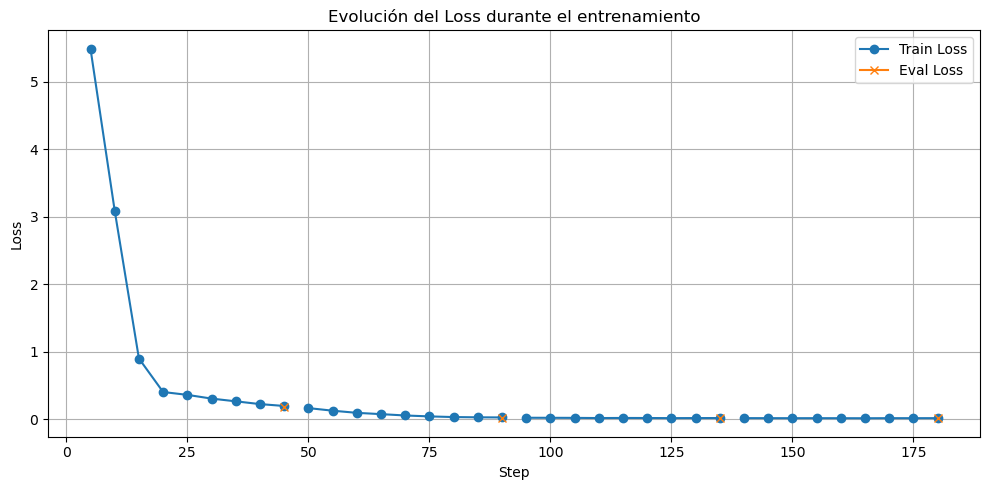

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Extraer los logs del entrenador
logs = trainer.state.log_history

# Convertir a DataFrame
df_logs = pd.DataFrame(logs)

# Filtrar solo los pasos con métricas
df_metrics = df_logs[df_logs['loss'].notna() | df_logs.get('eval_loss', pd.Series()).notna()]

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(df_metrics["step"], df_metrics["loss"], label="Train Loss", marker='o')
if "eval_loss" in df_metrics.columns:
    plt.plot(df_metrics["step"], df_metrics["eval_loss"], label="Eval Loss", marker='x')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Evolución del Loss durante el entrenamiento")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
import torch

# Poner el modelo en evaluación y en el dispositivo adecuado
model.eval()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# Texto de entrada
prompt = "Quiero una tarifa barata para coche eléctrico y con discriminación horaria."
inputs = tokenizer(prompt, return_tensors="pt").to(device)

# Generar texto
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=100,
        temperature=0.7,
        do_sample=True,
        top_p=0.9,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
    )

# Decodificar
respuesta = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(respuesta)

Quiero una tarifa barata para coche eléctrico y con discriminación horaria. ¿Qué tarifa me recomiendas?
La tarifa recomendada para ti es: Tarifa AhorroLuz.


In [23]:
from huggingface_hub import HfApi, HfFolder

# Autenticación con tu token
HfFolder.save_token(HF_TOKEN)

# Crear repositorio en Hugging Face (solo la primera vez)
from huggingface_hub import create_repo
create_repo("mi-modelo-tarifas", private=True)

# Subir el modelo
model.push_to_hub("mi-modelo-tarifas")
tokenizer.push_to_hub("mi-modelo-tarifas")

adapter_model.safetensors:   0%|          | 0.00/6.30M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ebarquin/mi-modelo-tarifas/commit/5d9306fd57d5b078fc0aea438c7a5404c2b0ec07', commit_message='Upload tokenizer', commit_description='', oid='5d9306fd57d5b078fc0aea438c7a5404c2b0ec07', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ebarquin/mi-modelo-tarifas', endpoint='https://huggingface.co', repo_type='model', repo_id='ebarquin/mi-modelo-tarifas'), pr_revision=None, pr_num=None)